In [33]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    run_dbscan, 
    transform_pca,
    silhouette_analysis,
    elbow_method,
    plot_davies_bouldin_scores,
    evaluar_calinski_harabasz
)


In [34]:
rfm_productos_extranjeros = pd.read_csv('../../../dataset/rfm_productos_extranjeros.csv')



print(rfm_productos_extranjeros.columns)

print("cantidad de columnas: ", len(rfm_productos_extranjeros.columns))

print("cantidad de filas: ", len(rfm_productos_extranjeros))

Index(['id_producto', 'Recency', 'Frequency', 'Monetary', 'n_paises_distintos',
       'horario_promedio', '2010-12', '2011-01', '2011-02', '2011-03',
       '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09',
       '2011-10', '2011-11', '2011-12', 'Australia', 'Austria', 'Bahrain',
       'Belgium', 'Brazil', 'Canada', 'Channel Islands', 'Cyprus',
       'Czech Republic', 'Denmark', 'EIRE', 'European Community', 'Finland',
       'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy', 'Japan',
       'Lebanon', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'RSA', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'USA', 'United Arab Emirates', 'Unspecified'],
      dtype='object')
cantidad de columnas:  55
cantidad de filas:  2781


In [35]:
rfm_productos_extranjeros.head()

,id_producto,Recency,Frequency,Monetary,n_paises_distintos,horario_promedio,2010-12,2011-01,2011-02,2011-03,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified
0,10002,253,422,358.7,6,11,108.0,193.0,1.0,0.0,...,0.0,0.0,0.0,0.0,24.0,0.0,12.0,0.0,0.0,0.0
1,10120,36,10,2.1,1,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10125,1,610,492.7,3,12,0.0,60.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
3,10133,114,130,67.5,5,12,20.0,0.0,10.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
4,10135,10,300,287.2,5,10,0.0,0.0,200.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['Recency', 'Frequency', 'Monetary']

# Mostrar estadísticas antes de la limpieza
print("Estadísticas ANTES de la limpieza de outliers:")
print(rfm_productos_extranjeros[columns_to_clean].describe())
print(f"\nCantidad de registros antes: {len(rfm_productos_extranjeros)}")

# Aplicar limpieza de outliers
rfm_productos_extranjeros_clean = remove_outliers_iqr(rfm_productos_extranjeros, columns_to_clean)

Estadísticas ANTES de la limpieza de outliers:
           Recency     Frequency      Monetary
count  2781.000000   2781.000000   2781.000000
mean     69.030924    326.311399    537.350708
std      92.414427    760.944895   1347.455107
min       1.000000      1.000000      0.190000
25%       6.000000     24.000000     40.680000
50%      25.000000     91.000000    148.500000
75%      81.000000    323.000000    525.000000
max     374.000000  15437.000000  31551.750000

Cantidad de registros antes: 2781


In [37]:
id_producto= rfm_productos_extranjeros['id_producto'].copy()

id_producto.head()

0    10002
1    10120
2    10125
3    10133
4    10135
Name: id_producto, dtype: object

In [38]:
rfm_productos_extranjeros.drop(columns=['id_producto','n_paises_distintos'], inplace=True)

In [39]:
rfm_productos_extranjeros

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified
0,253,422,358.7,11,108.0,193.0,1.0,0.0,120.0,0.0,...,0.0,0.0,0.0,0.0,24.0,0.0,12.0,0.0,0.0,0.0
1,36,10,2.1,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,610,492.7,12,0.0,60.0,0.0,40.0,20.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
3,114,130,67.5,12,20.0,0.0,10.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
4,10,300,287.2,10,0.0,0.0,200.0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,78,4,6.6,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2777,78,4,6.6,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2778,78,6,15.3,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2779,78,6,12.6,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## DBSCAN

### Reduccion de dimensionalidad

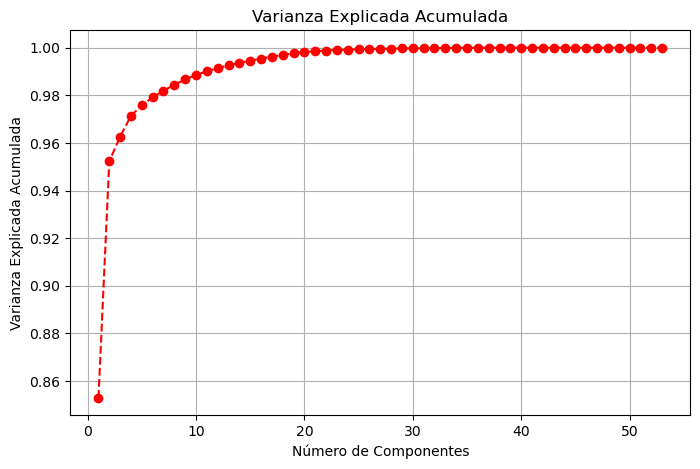

In [40]:
pca=PCA()

pca.fit(rfm_productos_extranjeros)

var_exp=pca.explained_variance_ratio_

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp.cumsum(), marker='o', linestyle='--', color='red')
plt.ylabel('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.title('Varianza Explicada Acumulada')
plt.grid()
plt.show()


In [41]:
# Calcular las componentes principales (2 componentes)
componentes = transform_pca(rfm_productos_extranjeros, 2)

# dichas compoenentes la transformamos en un dataframe de pandas , con los mismos indices que el dataframe original , para hacer un analisis psoteriormente de los grupos que forma k-means
dataframe_pca = pd.DataFrame(componentes, columns=['PC1','PC2'],index=rfm_productos_extranjeros.index)

dataframe_pca.head()



,PC1,PC2
0,0.461013,0.199421
1,-0.041844,-0.129109
2,-0.177558,-0.047074
3,0.118704,0.031313
4,-0.152568,-0.010904


### DBSCAN

In [42]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import optuna
def objective(trial):
    eps = trial.suggest_float('eps', 0.1, 20, step=0.1)
    min_samples = trial.suggest_int('min_samples', 3, 50)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(dataframe_pca.values)

    # Filtrar casos con solo ruido o un único clúster
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        return -9999.0  # Penalización fuerte

    X = dataframe_pca.values

    silhouette = silhouette_score(dataframe_pca.values, labels)
    calinski = calinski_harabasz_score(dataframe_pca.values, labels)
    davies = davies_bouldin_score(dataframe_pca.values, labels)

    # Normalizamos CH (opcional) y restamos DB
    # Pesos: silhouette (60%), calinski (40%), davies (-20%)
    score = (
        0.6 * silhouette +
        0.4 * (calinski / 100) - 
        0.2 * davies
    )

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Mejores hiperparámetros encontrados:")
print(study.best_params)

print("\nMejor puntuación compuesta obtenida:")
print(study.best_value)



[I 2025-07-14 11:14:06,540] A new study created in memory with name: no-name-c6d5ff8c-60c9-4467-a77b-17e9c79a5083
[I 2025-07-14 11:14:06,640] Trial 0 finished with value: -9999.0 and parameters: {'eps': 18.900000000000002, 'min_samples': 37}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:14:06,733] Trial 1 finished with value: -9999.0 and parameters: {'eps': 10.6, 'min_samples': 48}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:14:06,827] Trial 2 finished with value: -9999.0 and parameters: {'eps': 13.700000000000001, 'min_samples': 3}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:14:06,930] Trial 3 finished with value: -9999.0 and parameters: {'eps': 18.000000000000004, 'min_samples': 24}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:14:07,035] Trial 4 finished with value: -9999.0 and parameters: {'eps': 9.0, 'min_samples': 7}. Best is trial 0 with value: -9999.0.
[I 2025-07-14 11:14:07,139] Trial 5 finished with value: -9999.0 and parameters: {'eps'

Mejores hiperparámetros encontrados:
{'eps': 18.900000000000002, 'min_samples': 37}

Mejor puntuación compuesta obtenida:
-9999.0


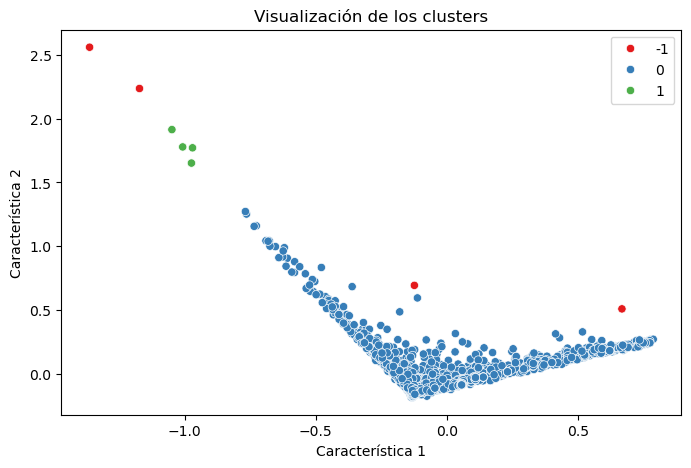

Run ID final clustering: 264af585b5bc4e30b2eeacb7d3c692d9
🏃 View run Final_Clustering_dbscan at: http://localhost:5000/#/experiments/620756252955281261/runs/264af585b5bc4e30b2eeacb7d3c692d9
🧪 View experiment at: http://localhost:5000/#/experiments/620756252955281261


,PC1,PC2,Cluster
0,0.461013,0.199421,0
1,-0.041844,-0.129109,0
2,-0.177558,-0.047074,0
3,0.118704,0.031313,0
4,-0.152568,-0.010904,0


In [43]:
data_clust = run_dbscan(dataframe_pca, 0.2, 4,experiment_name="DBSCAN_Productos_Extranjeros")

data_clust.head()



In [44]:
id_producto.index = data_clust.index

In [45]:
data_clust['id_producto'] = id_producto

In [46]:
data_clust = data_clust[['id_producto', 'PC1', 'PC2', 'Cluster']]

In [47]:
cluster_distintos=data_clust['Cluster'].unique()

print(cluster_distintos)



[ 0 -1  1]


In [48]:
rfm_productos_extranjeros['Cluster']=data_clust['Cluster']
rfm_productos_extranjeros['id_producto']=id_producto

In [49]:
rfm_productos_extranjeros.head()

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified,Cluster,id_producto
0,253,422,358.7,11,108.0,193.0,1.0,0.0,120.0,0.0,...,0.0,0.0,24.0,0.0,12.0,0.0,0.0,0.0,0,10002
1,36,10,2.1,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10120
2,1,610,492.7,12,0.0,60.0,0.0,40.0,20.0,100.0,...,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0,10125
3,114,130,67.5,12,20.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0,10133
4,10,300,287.2,10,0.0,0.0,200.0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10135


In [50]:
rfm_productos_extranjeros.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA', 'Saudi Arabia',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
       'United Arab Emirates', 'Unspecified', 'Cluster', 'id_producto'],
      dtype='object')

In [51]:
cluster_summary = rfm_productos_extranjeros.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified
Cluster,,,,,,,,,,,,,,,,,,,,,
-1,131.000000,6638.250000,3601.982500,11.750000,636.000000,915.000000,195.250000,705.000000,261.000000,669.500000,...,129.500000,0.000000,0.00000,6.000000,87.000000,975.000000,135.000000,15.000000,9.000000,6.000000
0,69.038226,304.031013,507.073895,12.122611,14.804904,23.288496,17.755499,23.909124,10.813559,23.899748,...,5.551388,0.126578,0.02885,1.878832,9.777858,11.541652,10.382979,0.862604,0.332131,0.635052
1,2.000000,9460.250000,18462.120000,12.000000,162.500000,582.500000,515.000000,706.000000,149.000000,636.000000,...,19.500000,0.000000,0.00000,0.000000,65.500000,33.000000,162.000000,1.500000,6.000000,0.000000


In [52]:
cluster_summary.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA', 'Saudi Arabia',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
       'United Arab Emirates', 'Unspecified'],
      dtype='object')

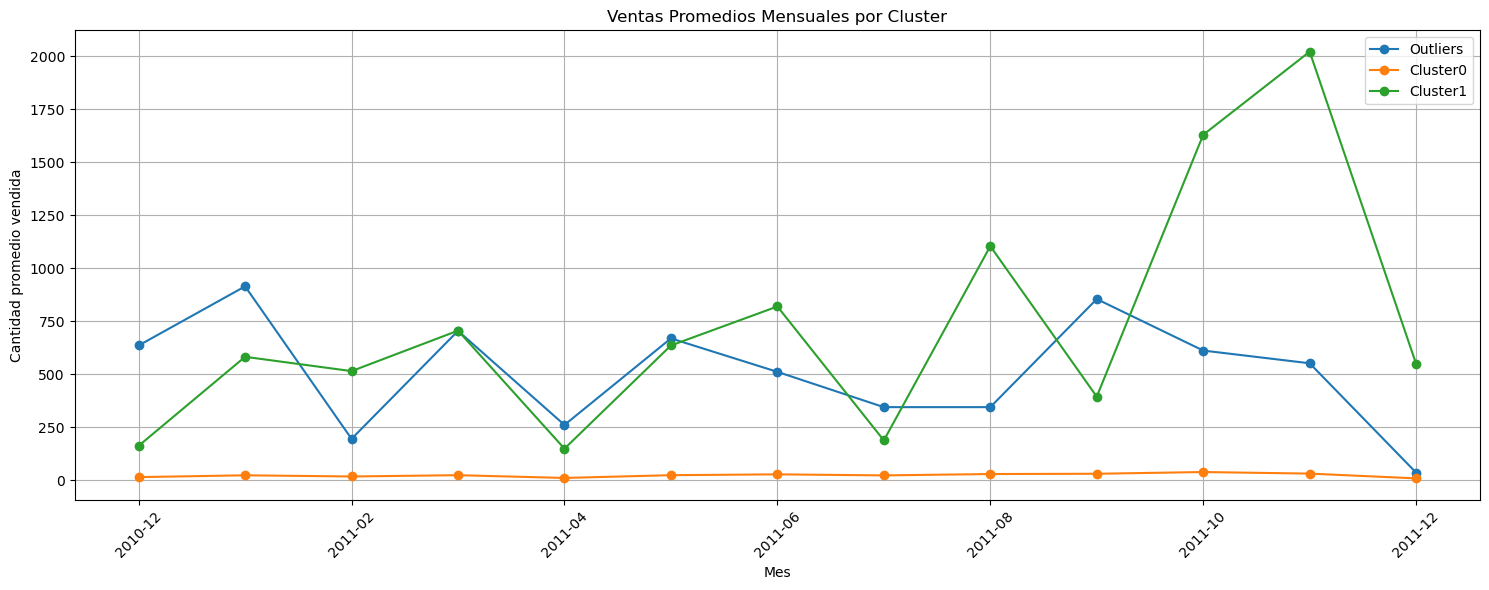

In [62]:
outliers_mes= cluster_summary.iloc[0].T
cluster0_mes= cluster_summary.iloc[1].T
cluster1_mes= cluster_summary.iloc[2].T


columnas_fechas = [col for col in rfm_productos_extranjeros.columns if col.startswith('201')]

outliers_mes=outliers_mes[columnas_fechas]
cluster0_mes=cluster0_mes[columnas_fechas]
cluster1_mes=cluster1_mes[columnas_fechas]

ventas_promedios_mensuales=pd.concat([outliers_mes,cluster0_mes,cluster1_mes],axis=1)
ventas_promedios_mensuales.columns=['Outliers','Cluster0','Cluster1']

ventas_promedios_mensuales.plot(
    figsize=(15, 6),
    title='Ventas Promedios Mensuales por Cluster',
    marker='o' ,
    markersize=6 )

plt.xlabel("Mes")
plt.ylabel("Cantidad promedio vendida")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
ventas_promedios_mensuales

,Outliers,Cluster0,Cluster1
2010-12,636.00,14.804904,162.50
2011-01,915.00,23.288496,582.50
2011-02,195.25,17.755499,515.00
2011-03,705.00,23.909124,706.00
2011-04,261.00,10.813559,149.00
2011-05,669.50,23.899748,636.00
2011-06,511.50,27.811396,820.00
2011-07,345.00,22.888568,188.00
2011-08,345.00,29.296430,1104.75
2011-09,855.00,30.634692,394.50


In [63]:
paises=['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA', 'Saudi Arabia',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
       'United Arab Emirates', 'Unspecified']


cantidad_de_paises=len(paises)
print(cantidad_de_paises)

outliers_paises=cluster_summary.iloc[0].T
cluester0_paises=cluster_summary.iloc[1].T
cluester1_paises=cluster_summary.iloc[2].T


outliers_paises=outliers_paises[paises]
cluester0_paises=cluester0_paises[paises]
cluester1_paises=cluester1_paises[paises]


venta_promedio_paises=pd.concat([outliers_paises,cluester0_paises,cluester1_paises],axis=1)
venta_promedio_paises.columns=['Outliers','Cluster 0','Cluster 1']


venta_promedio_paises.head(5)


36


,Outliers,Cluster 0,Cluster 1
Australia,828.0,27.524702,1063.0
Austria,15.0,1.690588,24.0
Bahrain,0.0,0.093761,0.0
Belgium,252.0,7.453300,321.5
Brazil,0.0,0.115398,9.0


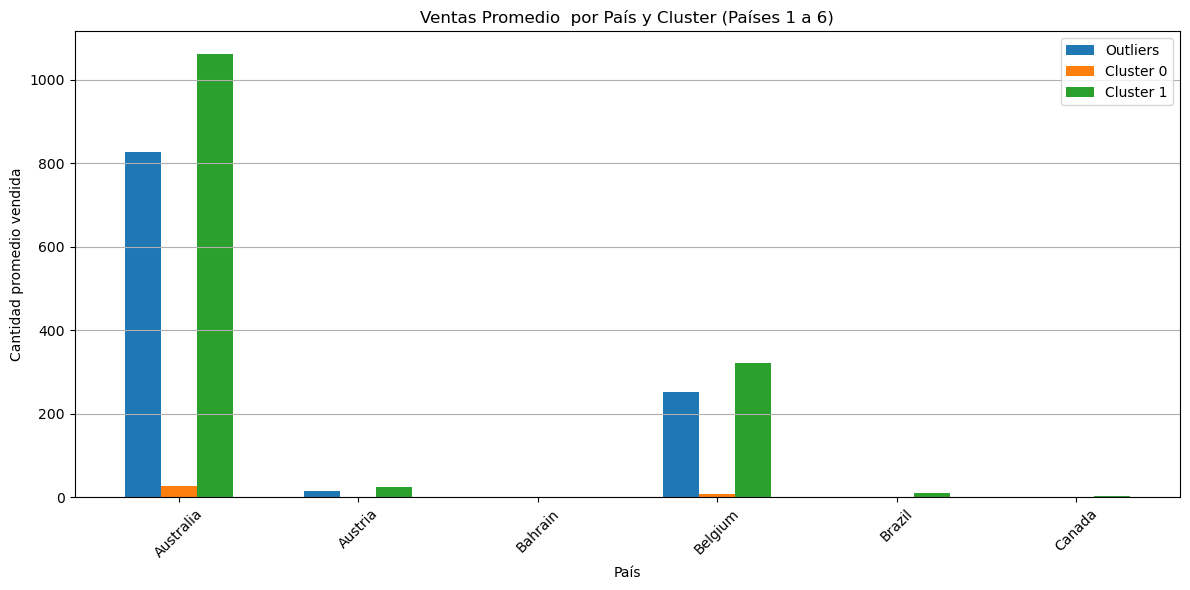

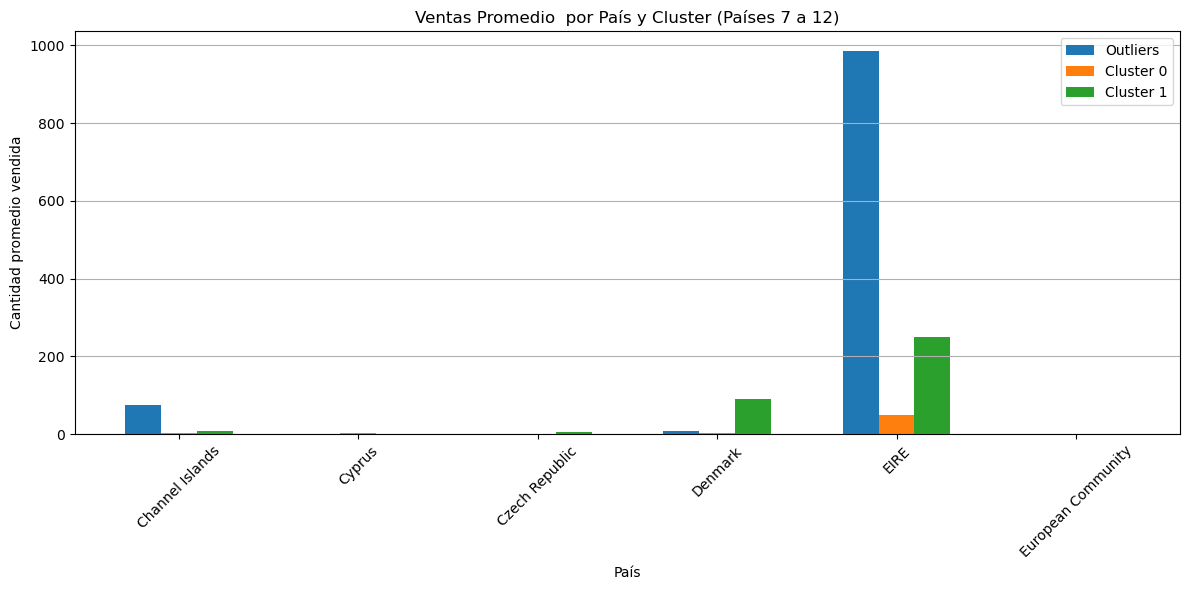

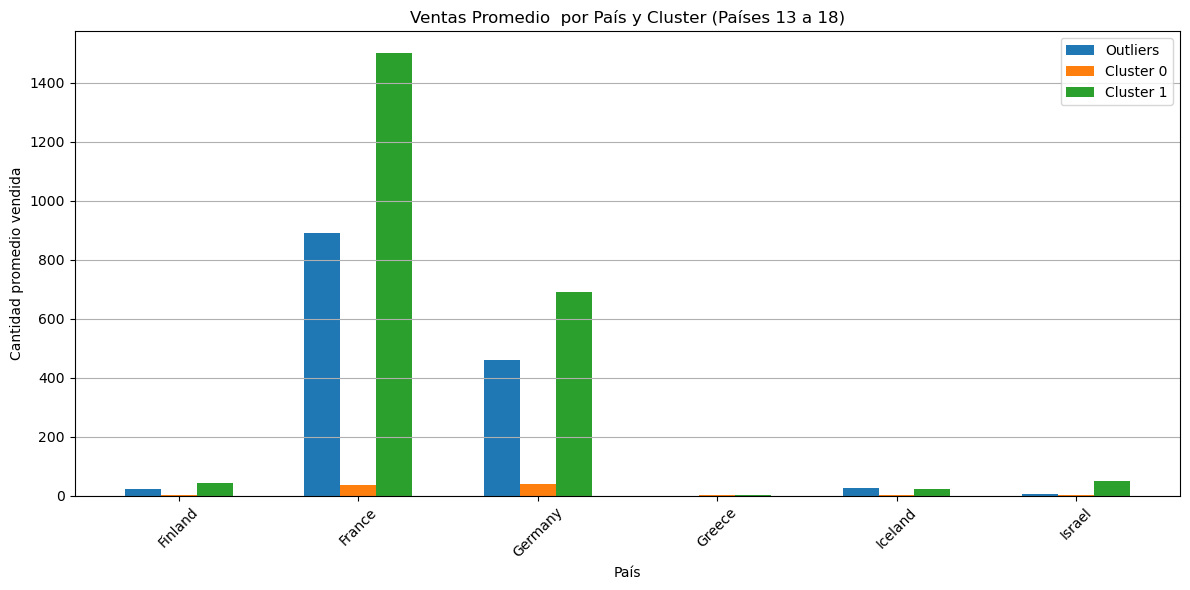

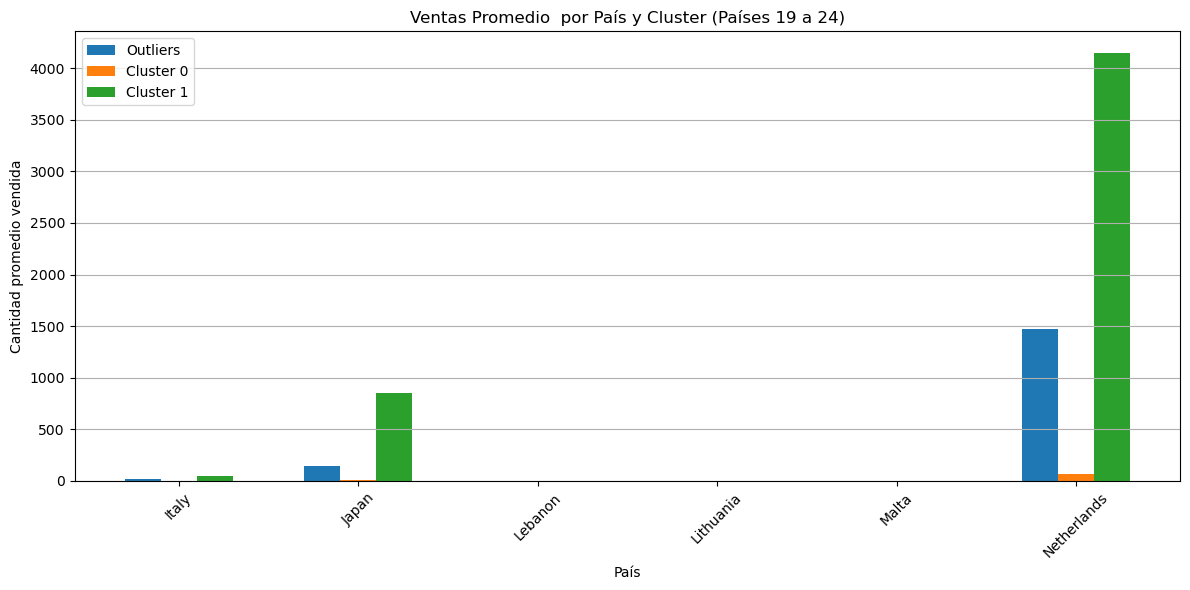

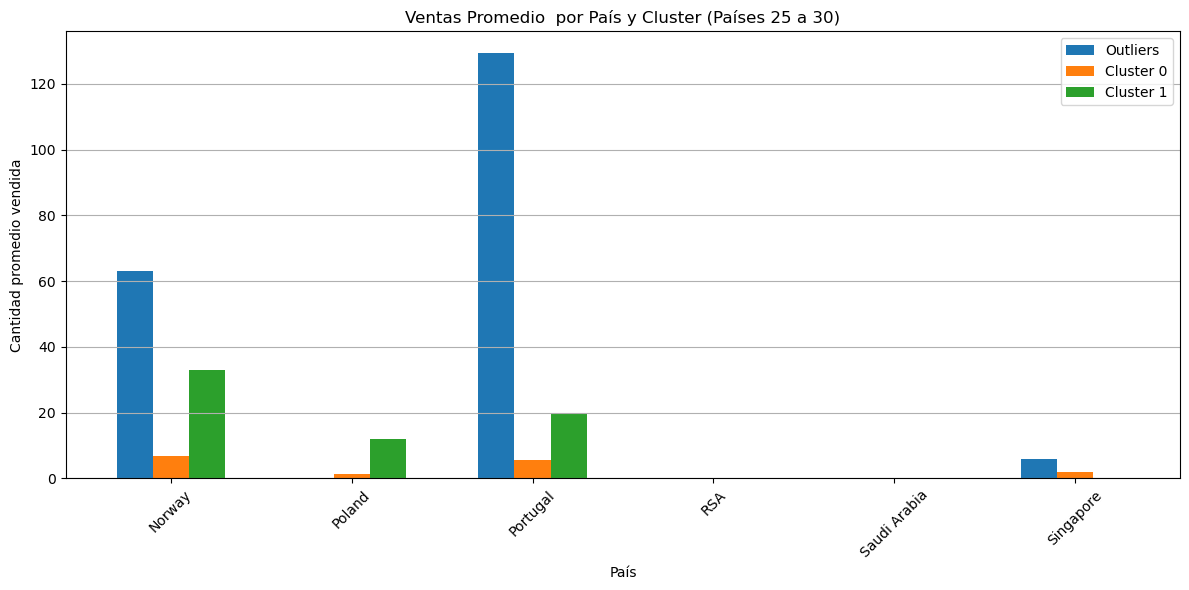

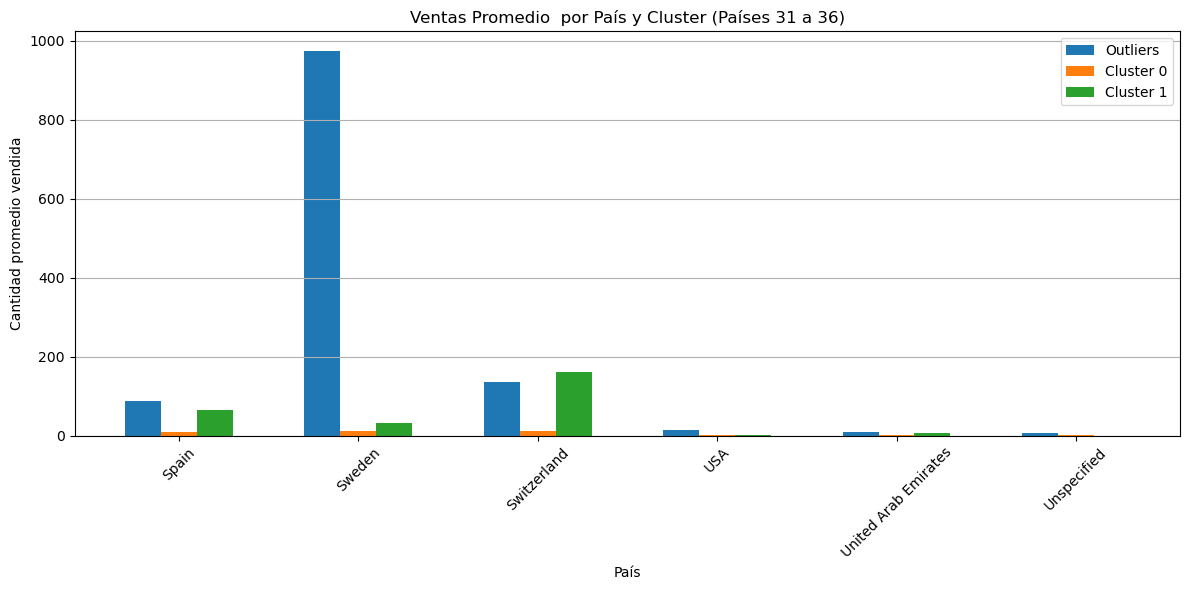

In [64]:

# Subconjunto de países y valores (6 países por lote)
lote = 6
total_paises = venta_promedio_paises.shape[0]
num_graficos = int(np.ceil(total_paises / lote))

for i in range(num_graficos):
    start = i * lote
    end = min(start + lote, total_paises)
    datos_lote = venta_promedio_paises.iloc[start:end]  # DataFrame con filas y 3 columnas

    # Parámetros para barras agrupadas
    n_paises = datos_lote.shape[0]
    n_clusters = datos_lote.shape[1]
    x = np.arange(n_paises)  # posiciones para países en eje X
    width = 0.2  # ancho de cada barra

    plt.figure(figsize=(12,6))
    for j in range(n_clusters):
        plt.bar(x + j*width, datos_lote.iloc[:, j], width=width, label=datos_lote.columns[j])

    plt.title(f'Ventas Promedio  por País y Cluster (Países {start+1} a {end})')
    plt.xlabel('País')
    plt.ylabel('Cantidad promedio vendida')
    plt.xticks(x + width, datos_lote.index, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


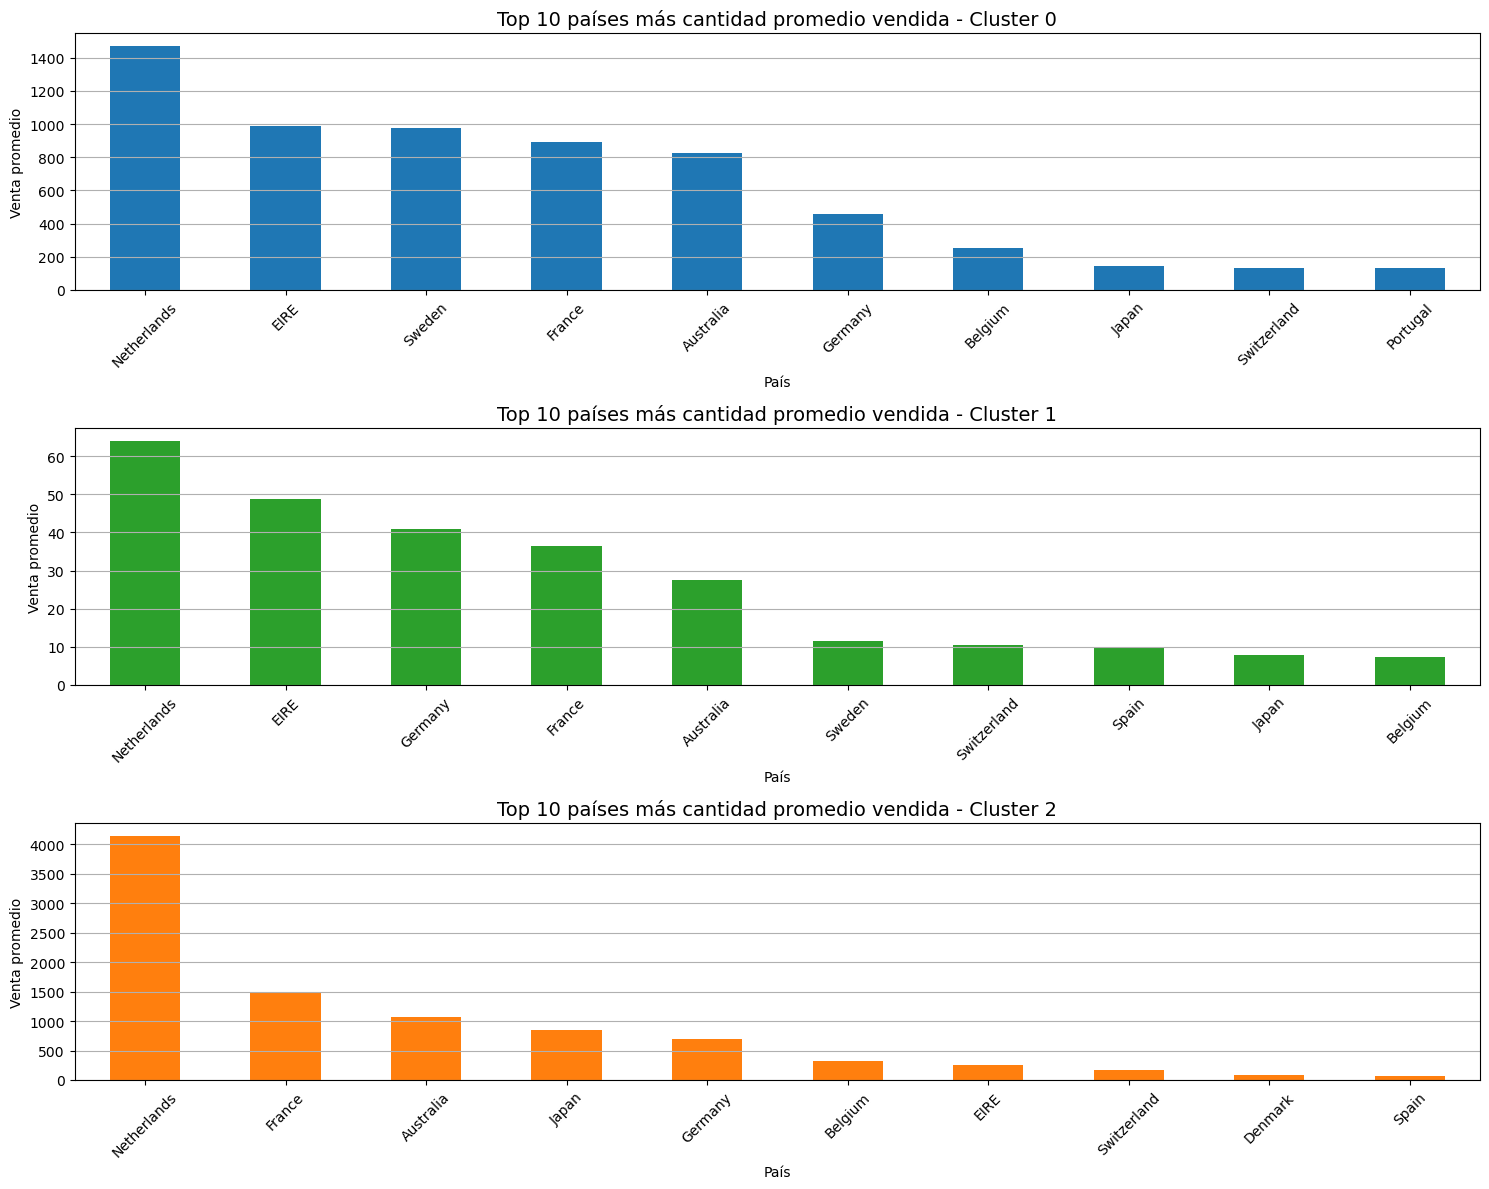

In [69]:
top_10_mas_vendido_outliers_pais = venta_promedio_paises.sort_values(by='Outliers', ascending=False)['Outliers'].head(10)
top_mas_vendido_cluster0_pais = venta_promedio_paises.sort_values(by='Cluster 0', ascending=False)['Cluster 0'].head(10)
top_mas_vendido_cluster1_pais = venta_promedio_paises.sort_values(by='Cluster 1', ascending=False)['Cluster 1'].head(10)


top_10_mas_vendido = [
    top_10_mas_vendido_outliers_pais, 
    top_mas_vendido_cluster0_pais, 
    top_mas_vendido_cluster1_pais, 

]
colors = ['#1f77b4', '#2ca02c','#ff7f0e']  
fig, axs = plt.subplots(3, 1, figsize=(15, 12))  

for i, cluster_data in enumerate(top_10_mas_vendido):
    cluster_data.plot(kind='bar', ax=axs[i], color=colors[i])
    axs[i].set_title(f'Top 10 países más cantidad promedio vendida - Cluster {i}', fontsize=14)
    axs[i].set_xlabel('País')
    axs[i].set_ylabel('Venta promedio')
    axs[i].set_xticks(range(len(cluster_data)))
    axs[i].set_xticklabels(cluster_data.index, rotation=45)
    axs[i].grid(axis='y')

plt.tight_layout()
plt.show()


In [71]:
rfm_columnas=['Recency', 'Frequency', 'Monetary']
outliers_rfm=cluster_summary.iloc[0].T
cluster0_rfm=cluster_summary.iloc[1].T
cluster1_rfm=cluster_summary.iloc[2].T

outliers_rfm=outliers_rfm[rfm_columnas]
cluster0_rfm=cluster0_rfm[rfm_columnas]
cluster1_rfm=cluster1_rfm[rfm_columnas]

rfm_promedio_cluster=pd.concat([outliers_rfm,cluster0_rfm,cluster1_rfm],axis=1)
rfm_promedio_cluster.columns=['Outliers','Cluster 0','Cluster 1']




In [72]:
rfm_promedio_cluster

,Outliers,Cluster 0,Cluster 1
Recency,131.0000,69.038226,2.00
Frequency,6638.2500,304.031013,9460.25
Monetary,3601.9825,507.073895,18462.12


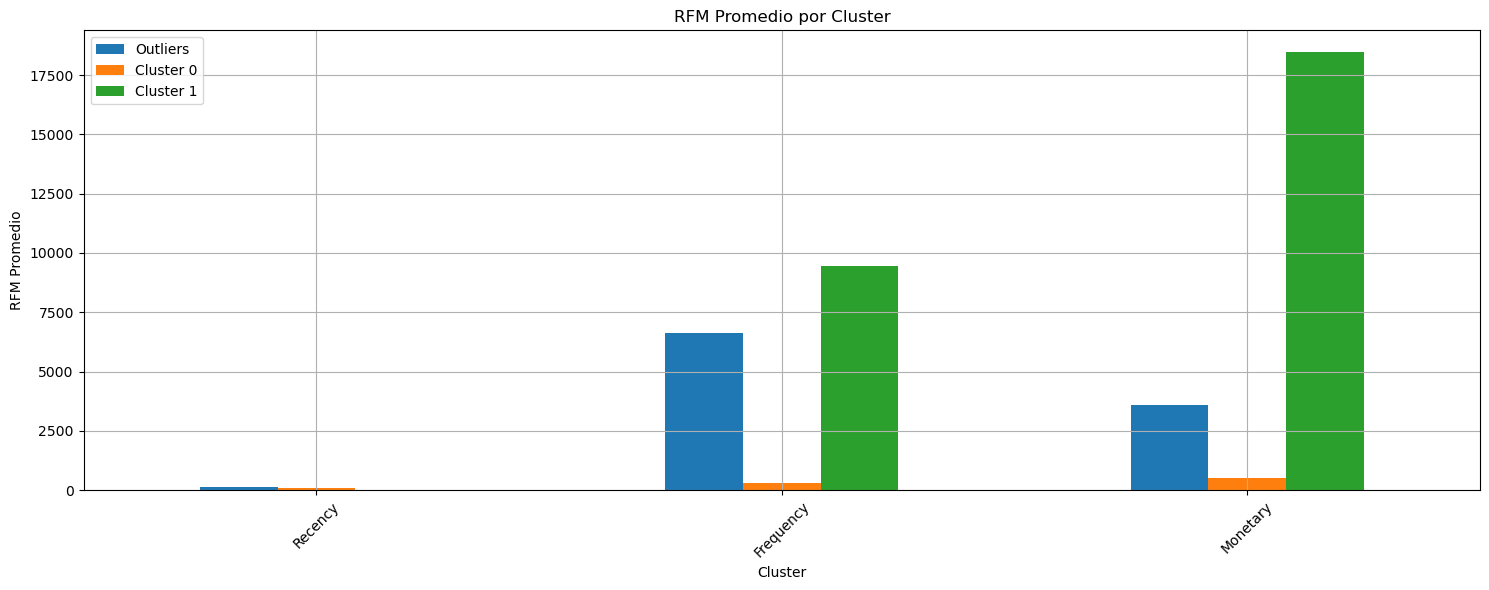

In [73]:
rfm_promedio_cluster.plot(kind='bar', figsize=(15, 6))
plt.title('RFM Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
productos_extrajeros_cluster= rfm_productos_extranjeros[['id_producto','Cluster']]

productos_extrajeros_cluster.to_csv('../../../dataset/dbscan_productos_extrajeros_cluster.csv',index=False)